# Eigenfaces

In this notebook, we apply the deterministic and randomized variants of the SVD to a large, real-life dataset. We will be using the [Labeled Faces in the Wild (LFW) dataset](http://vis-www.cs.umass.edu/lfw/), which consists of ~$8000$ RGB images of dimensions $250\times 250$. It's computationally infeasible for us to use the whole dataset, so we load a subset (1000 images).

### import packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import glob
from time import perf_counter
from tqdm import tqdm, trange

%matplotlib inline

In [2]:
%cd ..
from rputil import *
%cd -

/mnt/c/Users/rishi/GitHub/icerm/random-projections
/mnt/c/Users/rishi/GitHub/icerm/random-projections/notebooks


### load data

We flatten each image to represent it as vector of length $250\cdot 250 \cdot 3 = 187500$. This will yield a data matrix $A$ of size $187500 \times 1000$.

In [3]:
m = 187500
n = 1000

data = np.empty((m, n))

for i,filename in enumerate(glob.iglob('../datasets/lfw/**/*.jpg', recursive = True)):
    if i >= n:
        break
    im=Image.open(filename)
    data[:,i] = np.asarray(im).flatten()
    im.close()

In [4]:
data /= 255 # convert from int to float representation

#### column-center the data

This allows us to interpret the data in terms of the way it deviates from an 'average' face.

In [5]:
data_mean = np.expand_dims(np.mean(data, axis=1), 1)
data -= data_mean

### calculate eigenfaces

We compute the singular value decomposition,
$$A = U \Sigma V^* \,,$$
and then truncate $U$, keeping only the first $k$ columns, to use it as a basis for a rank-$k$ approximation.

Similarly, we use random projection to compute a randomized approximation of the SVD.

In [6]:
start = perf_counter()
det_U, det_Sigma, det_Vh = np.linalg.svd(data, full_matrices=False)
end = perf_counter()
det_time = end - start

In [7]:
k = 350

In [8]:
det_basis = det_U[:,:k]
print(det_basis.shape)

(187500, 350)


In [9]:
rand_basis = random_svd_rank_k(data, k, power=0, only_basis=True)
print(rand_basis.shape)

(187500, 350)


In [10]:
def normalize_basis(basis):
    return (basis - np.min(basis))/(np.max(basis)-np.min(basis))

In [11]:
normalized_det_basis = normalize_basis(det_basis)

In [12]:
normalized_rand_basis = normalize_basis(rand_basis)

Let's take a look at some of the first few faces in the dataset.

Some things to note:
- there can be multiple pictures of the same person
- the faces are all mostly centered and facing straight, but there are some exceptions

In [13]:
def plot_examples(rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15 / cols * rows))
    for i,ax in enumerate(axes.flat):
        ax.imshow((data[:,i]+np.squeeze(data_mean)).reshape(250,250,3))

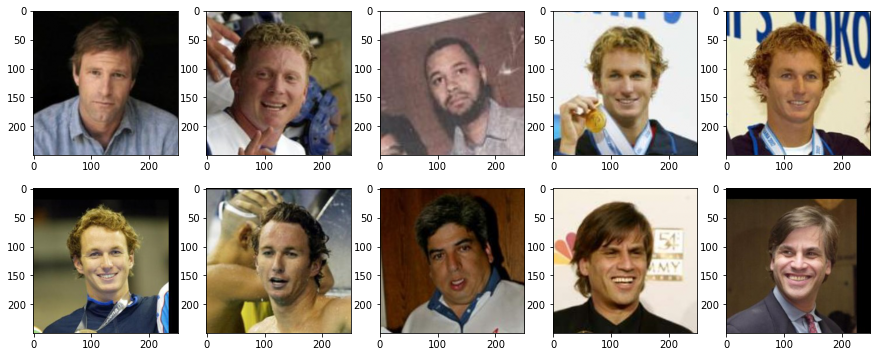

In [14]:
plot_examples(2, 5)

And now the eigenvectors, or 'eigenfaces,' comprising a basis for the image space:

In [15]:
def plot_eigenfaces(basis, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(15, 15 / cols * rows))
    for i in range(rows):
        for j in range(cols):
            ax[i][j].imshow(basis[:,i * cols + j].reshape(250,250,3))

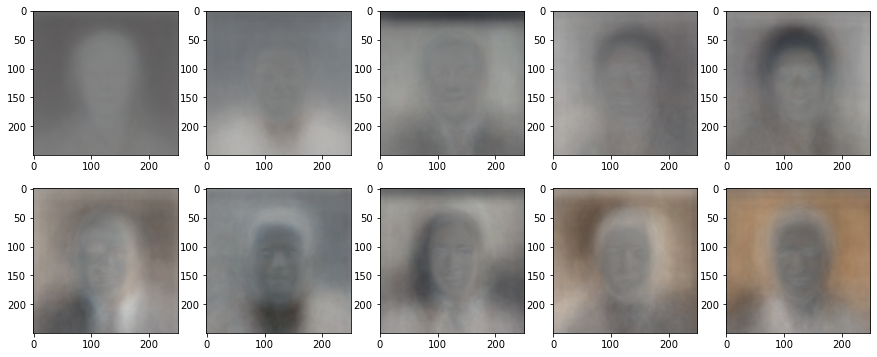

In [16]:
plot_eigenfaces(normalized_det_basis, 2, 5)

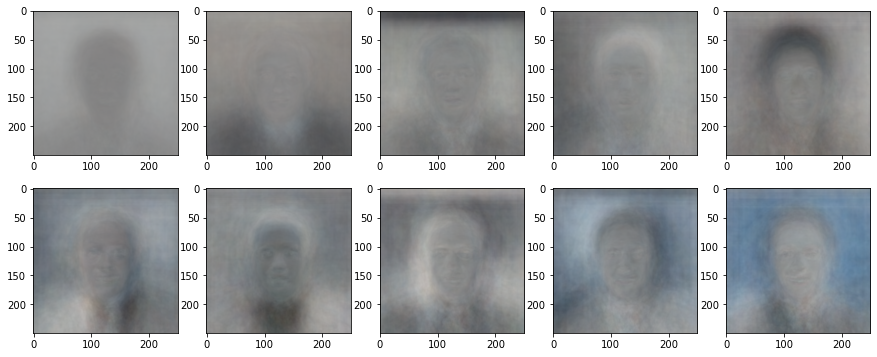

In [17]:
plot_eigenfaces(normalized_rand_basis, 2, 5)

### reconstruct an image 

Now that we have a basis, we may represent arbitrary vectors in our image space as linear combinations of basis vectors. To do this, we solve the linear system
$$A\vec{x}=\vec{b}-m \,,$$
where $A$ denotes the matrix of which our basis vectors are columns, $\vec{b}$ denotes our specific image, and $m$ denotes the (column) mean of the dataset. Since we know our basis is orthonormal, we can use a shortcut, computing the coefficients $\vec{x}$ as 
$$\vec{x} = (\vec{b}-m)A \,.$$

The reason why this technique is useful is that any arbitrary image that is similar to those in the dataset may be represented well using this basis.

In [18]:
specific_image = np.asarray(Image.open('../examples/eigenfaces/sean250.png')).flatten() / 255

In [19]:
det_coefficients = (specific_image - np.squeeze(data_mean)) @ det_basis

In [20]:
rand_coefficients = (specific_image - np.squeeze(data_mean)) @ rand_basis

In [21]:
det_reconstructed_image = np.squeeze(data_mean) + (det_basis @ det_coefficients)

In [22]:
rand_reconstructed_image = np.squeeze(data_mean) + (rand_basis @ rand_coefficients)

Here is an example of a face reconstructed using the eigenfaces:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


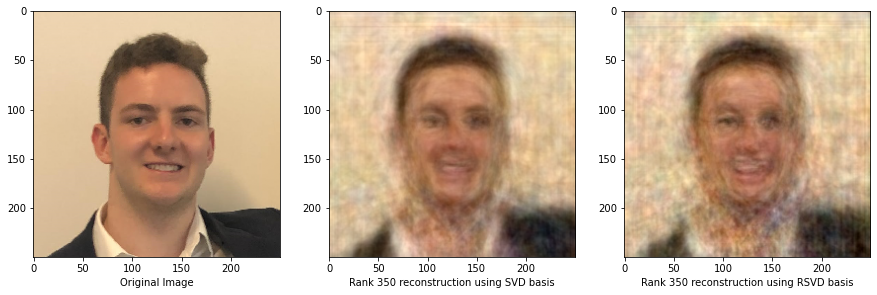

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].imshow(specific_image.reshape(250,250,3))
ax[0].set_xlabel('Original Image')
ax[1].imshow(det_reconstructed_image.reshape(250,250,3))
ax[1].set_xlabel(f'Rank-{k} reconstruction using SVD basis')
ax[2].imshow(rand_reconstructed_image.reshape(250,250,3))
ax[2].set_xlabel(f'Rank-{k} reconstruction using RSVD basis');

These animations show the quality of the image representation as we increase the rank of the matrix approximation:

Aaron Eckhart | Sean | President Obama | Ellie Goulding
- | - | - | -
![Guy](../examples/eigenfaces/guy250.png) | ![Sean](../examples/eigenfaces/sean250.png) | ![Pres](../examples/eigenfaces/president_obama250.png) | ![Ellie](../examples/eigenfaces/ellie250.png)
![Anim](../presentations/images/2020-07-10/anim/guy.gif) | ![Anim](../presentations/images/2020-07-10/anim/sean.gif) | ![Anim](../presentations/images/2020-07-10/anim/pres.gif) | ![Anim](../presentations/images/2020-07-10/anim/ellie.gif)

## statistical analysis

We have seen visually that we are able to compute high-quality approximations to faces, whether they are in the dataset or not. Now, we run several experiments to back up our visual intuition with hard numbers.

### relative error of RSVD compared to SVD

We compute approximations for varying ranks $k$, and evaluate the relative error for each rank.

In [24]:
domain = np.arange(50, 550, step=50)

rand_times = []
errors = []

for k in tqdm(domain):
    det_approx = svd_rank_k(data, k)
    
    start = perf_counter()
    rand_approx = random_svd_rank_k(data, k, power=0)
    end = perf_counter()
    rand_time = end - start
    
    rand_times.append(rand_time / det_time)
    
    
    error = (np.linalg.norm(data - rand_approx) 
             - np.linalg.norm(data - det_approx)) / np.linalg.norm(data - det_approx)
    errors.append(error)

100%|██████████| 10/10 [10:50<00:00, 65.07s/it]


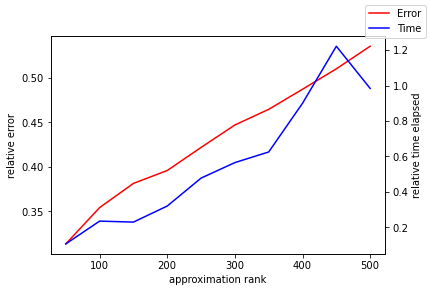

In [25]:
fig, ax = plt.subplots()

ax.set_xlabel('approximation rank')

ax.plot(domain, errors, c='r', label='Error')
ax.set_ylabel('relative error')

ax2 = ax.twinx()

ax2.plot(domain, rand_times, c='b', label='Time')
ax2.set_ylabel('relative time elapsed')

fig.legend(loc='upper right');

### RSVD/SVD error relative to original images

Here we compare the quality of the RSVD and SVD approximations to the original images.

In [26]:
n_sample = 10
rsvd_error = np.empty((domain.shape[0], n_sample))
svd_error = np.empty(domain.shape[0])

rsvd_stat = np.empty((7,domain.shape[0]))

for i in trange(domain.shape[0]):
    svd_error[i] = np.linalg.norm((det_U[:,:domain[i]] 
                                   @ np.diag(det_Sigma[:domain[i]]) 
                                   @ det_Vh[:domain[i]]) 
                                  - data) / np.linalg.norm(data)
    for j in range(n_sample):
        rsvd_error[i][j] = np.linalg.norm(random_svd_rank_k(data, domain[i], power=0) 
                                          - data) / np.linalg.norm(data)

100%|██████████| 10/10 [23:45<00:00, 142.57s/it]


In [27]:
for i in range(domain.shape[0]):
    rsvd_stat[0][i] = np.min(rsvd_error[i])
    rsvd_stat[1][i] = np.quantile(rsvd_error[i], 0.25)
    rsvd_stat[2][i] = np.median(rsvd_error[i])
    rsvd_stat[3][i] = np.quantile(rsvd_error[i], 0.75)
    rsvd_stat[4][i] = np.max(rsvd_error[i])
    rsvd_stat[5][i] = np.mean(rsvd_error[i])
    rsvd_stat[6][i] = np.std(rsvd_error[i])

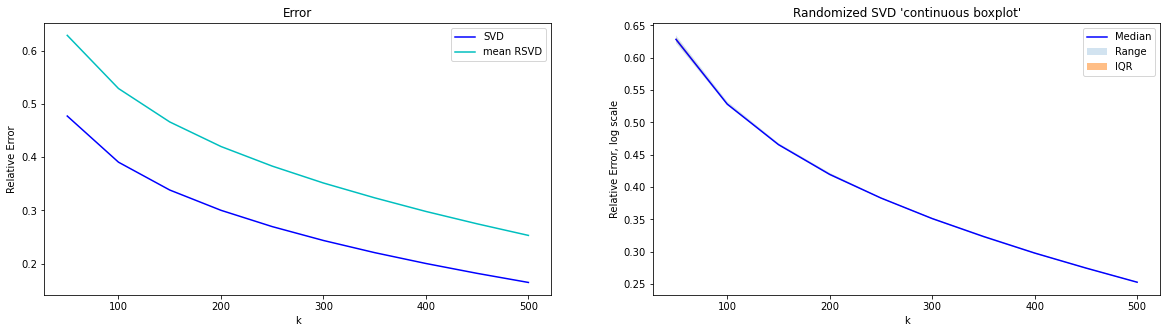

In [31]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(domain, svd_error, c='b', label='SVD')
ax[0].plot(domain, rsvd_stat[5], c='c', label='mean RSVD')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error')
# ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_title('Error')

ax[1].plot(domain, rsvd_stat[2], c='b', label='Median')
ax[1].fill_between(domain, rsvd_stat[4], rsvd_stat[0], alpha=0.2, label='Range', lw=1)
ax[1].fill_between(domain, rsvd_stat[1], rsvd_stat[3], alpha=0.5, label='IQR', lw=1)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Relative Error, log scale')
# ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_title('Randomized SVD \'continuous boxplot\'')


plt.show()

In [29]:
print(f"For k=200: Mean={rsvd_stat[5][3]}, StDev={rsvd_stat[6][3]}")

For k=200: Mean=0.419911538768576, StDev=0.0011398729811624255


While the relative accuracy for both SVD and RSVD isn't perfect for particularly low-rank approximations, it is still reasonable. With more computing power, we could run the decompositions on more data and potentially get better results.

Another thing to note is the high precision of the RSVD approximation (due to the concentration of measure phenomenon).